In [3]:
!pip install ultralytics opencv-python-headless numpy pytesseract
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
import pytesseract
from matplotlib import pyplot as plt


In [5]:
# Load a YOLOv8 model pretrained on the COCO dataset
model = YOLO('yolov8n.pt')  # You can choose 'yolov8s.pt', 'yolov8m.pt', etc.


100%|██████████| 6.25M/6.25M [00:00<00:00, 261MB/s]


In [34]:
image_path = "/content/Cars101.png"
image = cv2.imread(image_path)
new_img =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

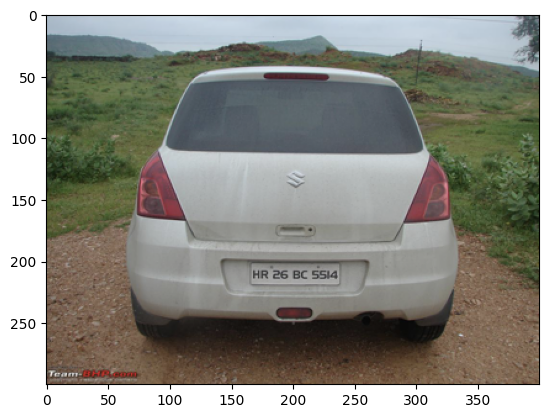

In [35]:
plt.imshow( new_img)


In [ ]:
# cap = cv2.VideoCapture('video_path.mp4')
# ret, frame = cap.read()
# cap.release()


In [ ]:
# # Convert frame to RGB (for display purposes)
# frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


image 1/1 /content/Cars101.png: 480x640 1 car, 71.7ms
Speed: 2.5ms preprocess, 71.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


array([[[207, 193, 180],
        [207, 193, 180],
        [205, 191, 178],
        ...,
        [ 76,  77,  66],
        [ 81,  80,  78],
        [ 66,  63,  68]],

       [[203, 190, 177],
        [203, 190, 177],
        [202, 188, 175],
        ...,
        [120, 120, 108],
        [113, 111, 107],
        [ 76,  74,  74]],

       [[201, 188, 174],
        [201, 188, 174],
        [199, 186, 172],
        ...,
        [123, 122, 107],
        [134, 131, 121],
        [ 81,  77,  72]],

       ...,

       [[ 65,  73, 108],
        [ 73,  83, 113],
        [ 81,  94, 116],
        ...,
        [ 57,  78, 106],
        [ 63,  85, 109],
        [ 82, 105, 127]],

       [[ 60,  73, 104],
        [ 72,  86, 114],
        [ 89, 105, 129],
        ...,
        [ 64,  87, 114],
        [ 68,  92, 115],
        [ 72,  97, 118]],

       [[ 71,  89, 118],
        [ 65,  84, 110],
        [ 84, 103, 128],
        ...,
        [ 83, 106, 133],
        [ 83, 107, 131],
        [ 95, 120, 141]]], dtype=uint8)
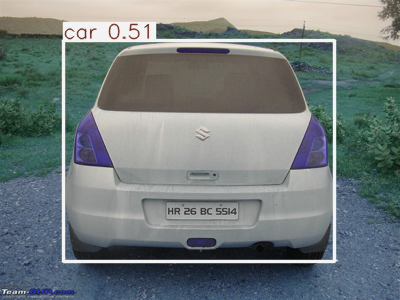

In [36]:
# Perform vehicle detection
results = model(image_path)  # If using an image
# results = model(frame)     # If using a frame from video

# Get the results
detections = results[0].cpu().numpy()

# Plot the detection results
results[0].plot(show=True)


In [37]:
# Extract bounding boxes and class IDs
vehicle_bboxes = []

# Access the first result (assuming a single image is processed)
result = results[0]

# Iterate over detections
for detection in result.boxes:
    bbox = detection.xyxy.cpu().numpy()  # Bounding box (x1, y1, x2, y2)
    class_id = int(detection.cls.cpu().numpy())  # Class ID

    # Check if the detection is a vehicle (car, motorcycle, bus, truck)
    if class_id in [2, 3, 5, 7]:  # These are the COCO class IDs for vehicles
        vehicle_bboxes.append(bbox)

<ipython-input-37-4250803602ff>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(detection.cls.cpu().numpy())  # Class ID


In [38]:
# Load the original image
image = cv2.imread(image_path)

# Function to extract license plate region
def extract_license_plate(vehicle_image):
    # Convert to grayscale
    gray = cv2.cvtColor(vehicle_image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection using Canny
    edged = cv2.Canny(blurred, 30, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    license_plate = None

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        if 2 < aspect_ratio < 5:  # The aspect ratio range for license plates
            license_plate = vehicle_image[y:y+h, x:x+w]
            break  # Assuming the first matching contour is the license plate

    return license_plate

License Plate 1: 


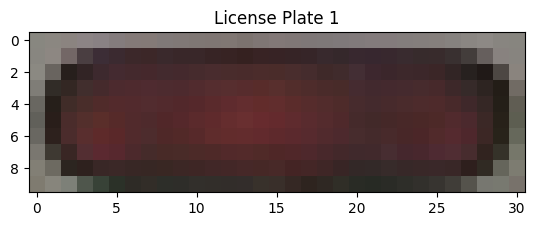

In [39]:
# Process each detected vehicle to find the license plate
license_plates = []

for bbox in vehicle_bboxes:
    x1, y1, x2, y2 = map(int, bbox[0])
    vehicle_img = image[y1:y2, x1:x2]
    license_plate_img = extract_license_plate(vehicle_img)
    if license_plate_img is not None:
        license_plates.append(license_plate_img)

# Perform OCR on each detected license plate
for idx, license_plate_img in enumerate(license_plates):
    gray_license_plate = cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY)
    plate_text = pytesseract.image_to_string(gray_license_plate, config='--psm 8')
    print(f"License Plate {idx + 1}: {plate_text.strip()}")

    # Display the license plate image
    plt.imshow(cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2RGB))
    plt.title(f"License Plate {idx + 1}")
    plt.show()